# ML Live

Bjoern Rost & Stewart Bryson

In [27]:
import datalab.bigquery as bq
import seaborn as sns
import pandas as pd
import numpy as np
import os
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# predict an output based on known inputs

* rate/demand forecasts
* probability of things like fraud or conversions
* package delivery times
* medical, eg: mortality rates for risk groups
* insurance risk

## traditional rules

~~~~
                   rules
                     ||
                     \/
             ----------------
 input ====> |  algorithm   |  =====> output
             ----------------
~~~~

## With Machine Learning

~~~~
                    data
                     ||
                     \/
             ----------------
 input ====> |   ML model   |  =====> output
             ----------------
~~~~

# Why Taxi Fares?

The city of New York made public a dataset with taxi > 150M rides per year since 2009. This makes it a great dataset for training because:

* one can easily relate to the data (we have all used taxis before)
* simple enough, one table with a handful of columns
* large enough to do relevant machine learning
* you can probably find blogs, notebooks etc from others about all aspects of this data

# NYC Taxi fares

Sounds easy enough to do with rules:

* initial charge \$2.50
* \$0.40 per 1/5 mile
* \$0.40 per 1 minute stopped/slow traffic
* \$1.00 Weekday Surcharge 4pm-8pm
* \$0.50 Night Surcharge 8pm-6am

But to calculate this before a trip you need to already know the route time and distance. We will use this route from LGA to midtown Manhattan as an example and you can see that there are different route options with different estimated times and mileages. These also vary highly with the amount of traffic over the course of a day.

![alt text](https://storage.cloud.google.com/brost-public/ml-live/sample_route.png "LGA to midtown")


# A quick look at the data

The dataset that we will use is a public data and conveniently available at several locations, including a <a href="https://bigquery.cloud.google.com/table/nyc-tlc:yellow.trips">BigQuery public dataset</a>. 

Let's write a SQL query to poke around.

In [3]:
%sql --module afewrecords
SELECT pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude,
dropoff_latitude, passenger_count, trip_distance, tolls_amount, 
fare_amount, total_amount FROM [nyc-tlc:yellow.trips] LIMIT 10

In [4]:
trips = bq.Query(afewrecords).to_dataframe()
trips

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2010-03-21 16:54:43,-73.973613,40.792270,-73.973670,40.792168,1,0.0,0.0,0.0,0.0
1,2010-02-09 06:48:04,-73.776446,40.646022,-73.776446,40.646022,1,0.0,0.0,0.0,0.0
2,2015-02-08 14:23:56,-73.937599,40.758228,-73.937614,40.758259,1,0.0,0.0,0.0,0.0
3,2010-02-02 21:16:08,-73.987630,40.757960,-73.984313,40.768847,1,0.0,0.0,0.0,0.0
4,2010-03-19 21:18:36,-73.984630,40.758817,-74.025551,40.754651,2,34.5,0.0,0.0,0.0
5,2013-08-22 20:39:00,-74.045757,40.740010,-74.045778,40.740040,1,0.0,0.0,0.0,0.0
6,2015-02-02 19:22:39,-73.937431,40.758427,-73.937691,40.758064,1,0.0,0.0,0.0,0.0
7,2015-01-16 16:05:23,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0.0
8,2010-02-15 10:55:12,-73.871434,40.771859,-73.885401,40.773195,1,1.4,0.0,0.0,0.0
9,2015-03-21 13:32:18,-73.937622,40.758221,-73.937622,40.758221,1,0.0,0.0,0.0,0.0


In [5]:
%sql --module lgapickup
SELECT pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude,
dropoff_latitude, passenger_count, trip_distance, tolls_amount, 
fare_amount, total_amount FROM [nyc-tlc:yellow.trips] where pickup_longitude = -73.885262 
and pickup_latitude = 40.773008
and dropoff_longitude = -73.987232
and dropoff_latitude = 40.732403 LIMIT 10

In [6]:
trips = bq.Query(lgapickup).to_dataframe()
trips

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2009-10-25 21:55:00,-73.885262,40.773008,-73.987232,40.732403,2,8.77,4.57,21.7,26.77


# What to do with this dataset?

* data cleanup
* reporting
* analytics and exploration
* machine learning


Let's increase the number of records so that we can do some neat graphs. There is no guarantee about the order in which records are returned, and so no guarantee about which records get returned if we simply increase the LIMIT. To properly sample the dataset, let's use the HASH of the pickup time and return 1 in 100,000 records -- because there are 1 billion records in the data, we should get back approximately 10,000 records if we do this.

In [7]:
%sql --module afewrecords2
SELECT
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  [nyc-tlc:yellow.trips]
WHERE
  ABS(HASH(pickup_datetime)) % $EVERY_N == 1

In [8]:
trips = bq.Query(afewrecords2, EVERY_N=100000).to_dataframe()
trips[:10]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2011-01-07 15:16:00,-73.912302,40.634552,-73.912302,40.634552,1,0.72,0.0,4.5,5.00
1,2011-08-22 15:55:00,-73.955008,40.785930,-73.967737,40.798777,5,1.48,0.0,6.5,8.00
2,2014-01-02 15:00:36,-73.981458,40.767420,-73.974968,40.759205,1,0.80,0.0,7.5,8.00
3,2012-09-27 04:16:16,-74.001429,40.736143,-74.001686,40.740959,1,1.40,0.0,8.0,11.70
4,2013-01-20 21:36:00,-73.952170,40.781197,-73.968655,40.796417,2,1.89,0.0,9.0,10.00
5,2012-09-12 02:41:25,-73.953663,40.770949,-73.976859,40.790250,1,2.30,0.0,10.5,12.50
6,2013-08-14 17:02:00,-73.970522,40.796477,-73.938022,40.804572,1,2.71,0.0,13.0,16.50
7,2014-09-28 02:44:39,-74.000736,40.727275,-73.928181,40.697652,1,4.80,0.0,18.0,21.00
8,2012-09-26 16:04:09,-73.862928,40.769067,-74.008260,40.708191,1,15.80,4.8,44.5,56.65
9,2011-05-23 14:50:00,-73.965558,40.768625,-73.945263,40.774295,2,1.68,0.0,7.3,7.80


<h3> Exploring data </h3>

Let's explore this dataset and clean it up as necessary. We'll use the Python Seaborn package to visualize graphs and Pandas to do the slicing and filtering.

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.regplot(x="trip_distance", y="fare_amount", fit_reg=False, ci=None, truncate=True, data=trips)

Hmm ... do you see something wrong with the data that needs addressing?

It appears that we have a lot of invalid data that is being coded as zero distance and some fare amounts that are definitely illegitimate. Let's remove them from our analysis. We can do this by modifying the BigQuery query to keep only trips longer than zero miles and fare amounts that are at least the minimum cab fare ($2.50).

Note the extra WHERE clauses.

In [9]:
%sql --module afewrecords3
SELECT
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  [nyc-tlc:yellow.trips]
WHERE
  (ABS(HASH(pickup_datetime)) % $EVERY_N == 1 AND
  trip_distance > 0 AND fare_amount >= 2.5)

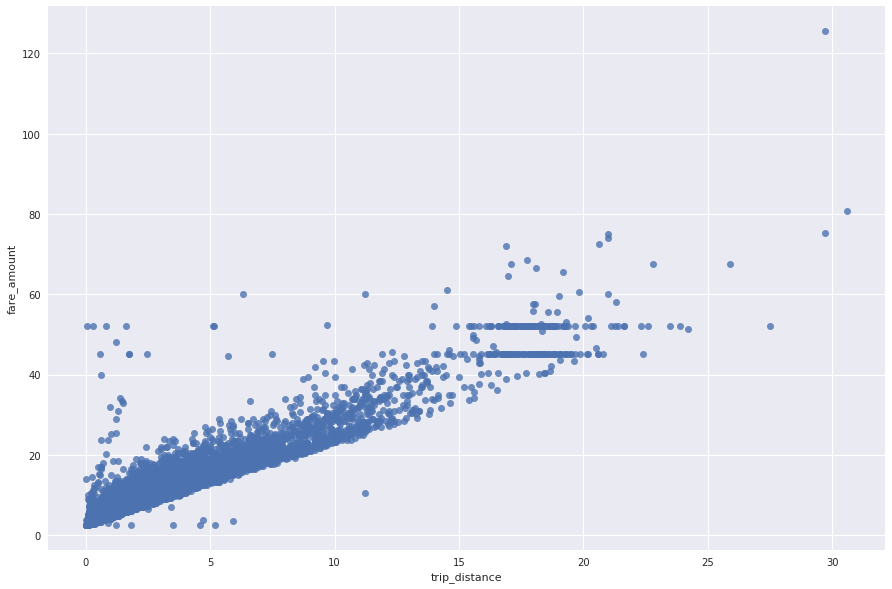

In [10]:
trips = bq.Query(afewrecords3, EVERY_N=100000).to_dataframe()
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.regplot(x="trip_distance", y="fare_amount", fit_reg=False, ci=None, truncate=True, data=trips)

What's up with the streaks at <span>$</span>45 and \$50?  Those are fixed-amount rides from JFK and La Guardia airports into anywhere in Manhattan, i.e. to be expected. Let's list the data to make sure the values look reasonable.

Let's examine whether the toll amount is captured in the total amount.

In [ ]:
tollrides = trips[trips['tolls_amount'] > 0]
tollrides[tollrides['pickup_datetime'] == '2012-09-05 15:45:00']

Looking a few samples above, it should be clear that the total amount reflects fare amount, toll and tip somewhat arbitrarily -- this is because when customers pay cash, the tip is not known.  So, we'll use the sum of fare_amount + tolls_amount as what needs to be predicted.  Tips are discretionary and do not have to be included in our fare estimation tool.

Let's also look at the distribution of values within the columns.

In [ ]:
trips.describe()

In [ ]:
def showrides(df, numlines):
  import matplotlib.pyplot as plt
  lats = []
  lons = []
  for iter, row in df[:numlines].iterrows():
    lons.append(row['pickup_longitude'])
    lons.append(row['dropoff_longitude'])
    lons.append(None)
    lats.append(row['pickup_latitude'])
    lats.append(row['dropoff_latitude'])
    lats.append(None)

  sns.set_style("darkgrid")
  fig, ax = plt.subplots()
  fig.set_size_inches(15, 10)
  plt.plot(lons, lats)

showrides(trips, 42)

In [ ]:
showrides(tollrides, 10)

<h3> Quality control and other preprocessing </h3>

We need to some clean-up of the data:
<ol>
<li>New York city longitudes are around -74 and latitudes are around 41.</li>
<li>We shouldn't have zero passengers.</li>
<li>Clean up the total_amount column to reflect only fare_amount and tolls_amount, and then remove those two columns.</li>
<li>Before the ride starts, we'll know the pickup and dropoff locations, but not the trip distance (that depends on the route taken), so remove it from the ML dataset</li>
<li>Discard the timestamp</li>
</ol>

We could do preprocessing in BigQuery, similar to how we removed the zero-distance rides, but just to show you another option, let's do this in Python.  In production, we'll have to carry out the same preprocessing on the real-time input data. 

This sort of preprocessing of input data is quite common in ML, especially if the quality-control is dynamic.

In [30]:
def preprocess(trips_in):
  trips = trips_in.copy(deep=True)
  trips.fare_amount = trips.fare_amount + trips.tolls_amount
  del trips['tolls_amount']
  del trips['total_amount']
  del trips['trip_distance']
  del trips['pickup_datetime']
  qc = np.all([\
             trips['pickup_longitude'] > -78, \
             trips['pickup_longitude'] < -70, \
             trips['dropoff_longitude'] > -78, \
             trips['dropoff_longitude'] < -70, \
             trips['pickup_latitude'] > 37, \
             trips['pickup_latitude'] < 45, \
             trips['dropoff_latitude'] > 37, \
             trips['dropoff_latitude'] < 45, \
             trips['passenger_count'] > 0,
            ], axis=0)
  return trips[qc]

tripsqc = preprocess(trips)
tripsqc.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,11101.000000,11101.000000,11101.000000,11101.000000,11101.000000,11101.000000
mean,-73.975294,40.751359,-73.974711,40.751343,1.730925,11.231066
std,0.038610,0.029801,0.038460,0.034012,1.343629,9.361325
min,-74.417107,40.277250,-74.417107,40.303627,1.000000,2.500000
25%,-73.992337,40.737100,-73.991878,40.735405,1.000000,6.000000
50%,-73.982062,40.753875,-73.980857,40.754000,1.000000,8.500000
75%,-73.968307,40.768101,-73.966165,40.768616,2.000000,12.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,130.120000


The quality control has removed about 300 rows (11400 - 11101) or about 3% of the data. This seems reasonable.
Let's move on to creating the ML datasets.

<h3> Create ML datasets </h3>

Let's split the QCed data randomly into training, validation and test sets.

In [55]:
shuffled = tripsqc.sample(frac=1)
trainsize = int(len(shuffled['fare_amount']) * 0.70)
validsize = int(len(shuffled['fare_amount']) * 0.15)

df_train = shuffled.iloc[:trainsize, :]
df_valid = shuffled.iloc[trainsize:(trainsize+validsize), :]

In [56]:
df_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,7770.000000,7770.000000,7770.000000,7770.000000,7770.000000,7770.000000
mean,-73.975647,40.750999,-73.974917,40.751072,1.736551,11.214363
std,0.036094,0.028356,0.036162,0.032640,1.345354,9.208529
min,-74.236488,40.277250,-74.243160,40.303627,1.000000,2.500000
25%,-73.992488,40.736751,-73.992001,40.735366,1.000000,6.000000
50%,-73.982122,40.753584,-73.980788,40.753989,1.000000,8.500000
75%,-73.968272,40.767932,-73.966301,40.768565,2.000000,12.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,88.000000


In [33]:
df_valid.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000
mean,-73.974533,40.752013,-73.973212,40.751527,1.730330,11.680943
std,0.041771,0.031142,0.042597,0.034500,1.326486,10.090750
min,-74.164770,40.587237,-74.177997,40.588857,1.000000,2.500000
25%,-73.992013,40.738190,-73.991287,40.735709,1.000000,6.100000
50%,-73.982007,40.754013,-73.980298,40.753807,1.000000,8.500000
75%,-73.969037,40.767833,-73.964414,40.769301,2.000000,12.900000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,80.250000


## Create test dataset directly from query

For testing we will actuallt be using the result of this query instead of the csv for the rest of this session. 

In [57]:
def create_query(phase, EVERY_N):
  """
  phase: 1=train 2=valid
  """
  base_query = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key,
  DAYOFWEEK(pickup_datetime)*1.0 AS dayofweek,
  HOUR(pickup_datetime)*1.0 AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """

  if EVERY_N == None:
    if phase < 2:
      # training
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 < 2".format(base_query)
    else:
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 == {1}".format(base_query, phase)
  else:
      query = "{0} AND ABS(HASH(pickup_datetime)) % {1} == {2}".format(base_query, EVERY_N, phase)
    
  return query

query = create_query(2, 100000)
df_test = bq.Query(query).to_dataframe()

In [58]:
df_test.describe()

,fare_amount,dayofweek,hourofday,pickuplon,pickuplat,dropofflon,dropofflat,passengers
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,11.333684,3.990014,13.467420,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,9.409953,1.960160,6.868584,0.042774,0.033541,0.039072,0.035435,1.278747
min,2.500000,1.000000,0.000000,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,6.100000,2.000000,8.000000,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,8.500000,4.000000,15.000000,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,12.500000,6.000000,19.000000,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,124.000000,7.000000,23.000000,-72.986532,41.709555,-72.990963,41.696683,6.000000


Let's write out the three dataframes to appropriately named csv files. We can use these csv files for local training (recall that these files represent only 1/100,000 of the full dataset) until we get to point of using Dataflow and Cloud ML.

The training set will be used to fit the model in the training phase.
Validation is for quick evaluation of the trained model, especially useful in comparing different training parameters.
The Test dataset is the final step and used to compare different models against each other. 

In [61]:
def to_csv(df, filename):
  outdf = df.copy(deep=False)
  outdf.loc[:, 'key'] = np.arange(0, len(outdf)) # rownumber as key
  # reorder columns so that target is first column
  cols = outdf.columns.tolist()
  cols.remove('fare_amount')
  cols.insert(0, 'fare_amount')
  print (cols)  # new order of columns
  outdf = outdf[cols]
  outdf.to_csv(filename, header=False, index_label=False, index=False)

! mkdir -p data
to_csv(df_train, 'data/taxi-train.csv')
to_csv(df_valid, 'data/taxi-valid.csv')
to_csv(df_test, 'data/taxi-test.csv')

['fare_amount', u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude', u'dropoff_latitude', u'passenger_count', 'key']
['fare_amount', u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude', u'dropoff_latitude', u'passenger_count', 'key']
['fare_amount', u'key', u'dayofweek', u'hourofday', u'pickuplon', u'pickuplat', u'dropofflon', u'dropofflat', u'passengers']


In [66]:
!head -10 data/taxi-train.csv

8.1,-73.981015,40.738629,-73.987788,40.757441,3,0
8.5,-74.008635,40.713638,-74.007537,40.741068,3,1
4.0,-73.97673797607422,40.759071350097656,-73.98375701904297,40.75236892700195,1,2
57.33,-73.92982,40.786064,-73.971336,40.787596,2,3
6.1,-74.002006,40.751448,-74.002006,40.751448,1,4
10.0,-73.95721,40.77478,-73.95666,40.80243,2,5
31.0,-73.7879867553711,40.64561080932617,-73.87115478515625,40.772254943847656,1,6
5.3,-73.987602,40.738475,-73.99903,40.731612,1,7
9.7,-73.966362,40.765275,-73.979556,40.737002,1,8
6.1,-73.995548,40.769567,-73.98313,40.761193,1,9


<h3> Verify that datasets exist </h3>

In [67]:
!ls -l data/*.csv

-rw-r--r-- 1 root root 648360 Oct 20 23:23 data/taxi-test.csv
-rw-r--r-- 1 root root 427119 Oct 20 23:23 data/taxi-train.csv
-rw-r--r-- 1 root root  90416 Oct 20 23:23 data/taxi-valid.csv


We have 3 .csv files corresponding to train, valid, test.  The ratio of file-sizes correspond to our split of the data. 

Looks good! We now have our ML datasets and are ready to train ML models, validate them and evaluate them.

# rule-based Benchmark

Before we start building actual ML models, it is a good idea to come up with a very simple model and use that as a benchmark.

The simplest model is going to be to derive the trip distance and calculate the mean rate per km (or mile). Then to predict the rate we multiply that average cost per km with the trip distance.
In the absence of a map routing engine, we will have to use the direct line between pickup and dropoff which is obviously flawed but simple and fast to calculate.

# scoring of accuracy

To compare the quality of different models we have to come up with a way to express the overall accuracy of a model. To do that we will run predictions against the same test training set and compare our predictions agains the known correct values. A simple way to aggregate all individual deviations or errors is the Root Mean Squared Error (RMSE). The calculation is

TODO: FORUMULA

The benefit of RMSE is that it is easy to calculate and the result is expressed in the same unit as the predicted label.

In [71]:
def distance_between(lat1, lon1, lat2, lon2):
  # haversine formula to compute distance "as the crow flies".  Taxis can't fly of course.
  dist = np.degrees(np.arccos(np.minimum(1,np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1))))) * 60 * 1.515 * 1.609344
  return dist

def estimate_distance(df):
  return distance_between(df['pickuplat'], df['pickuplon'], df['dropofflat'], df['dropofflon'])

def compute_rmse(actual, predicted):
  return np.sqrt(np.mean((actual-predicted)**2))

def print_rmse(df, rate, name):
  print ("{1} RMSE = {0}".format(compute_rmse(df['fare_amount'], rate*estimate_distance(df)), name))

FEATURES = ['pickuplon','pickuplat','dropofflon','dropofflat','passengers']
TARGET = 'fare_amount'
columns = list([TARGET])
columns.extend(FEATURES) # in CSV, target is the first column, after the features
columns.append('key')
df_train = pd.read_csv('data/taxi-train.csv', header=None, names=columns)
df_valid = pd.read_csv('data/taxi-valid.csv', header=None, names=columns)
rate = df_train['fare_amount'].mean() / estimate_distance(df_train).mean()
print ("Rate = ${0}/km".format(rate))
print_rmse(df_train, rate, 'Train')
print_rmse(df_valid, rate, 'Valid')  

Rate = $2.56200349848/km
Train RMSE = 6.91969058386
Valid RMSE = 5.73966652283


### Benchmark on test dataset
The RMSE depends on the dataset, and for comparison, we have to evaluate on the same dataset each time. We'll use this query in later labs:

In [72]:
print_rmse(df_test, 2.56, 'Final Validation Set')

Final Validation Set RMSE = 8.02634667918


The simple distance-based rule gives us a RMSE of about <b>$8</b>.  We have to beat this, of course, but you will find that simple rules of thumb like this can be surprisingly difficult to beat.

Let's be ambitious, though, and make our goal to build ML models that have a RMSE of less than $6 on the test set.

# Machine Learning using Tensorflow

Tensorflow is a popular open source machine learning library. Beyond basic algorithms it supports distributed training on neural networks. We will start with a linear regression model using tf.estimator and evaluate its performance. Tensorflow can run both locally or on a remote compute cluster. We will start with a small dataset (<10k records) so we can do it all in-memory on the VM that this notebook is running on. We will also just pass the data in as-is. 

In [73]:
# In CSV, label is the first column, after the features, followed by the key
CSV_COLUMNS = ['fare_amount', 'pickuplon','pickuplat','dropofflon','dropofflat','passengers', 'key']
FEATURES = CSV_COLUMNS[1:len(CSV_COLUMNS) - 1]
LABEL = CSV_COLUMNS[0]

df_train = pd.read_csv('./data/taxi-train.csv', header = None, names = CSV_COLUMNS)
df_valid = pd.read_csv('./data/taxi-valid.csv', header = None, names = CSV_COLUMNS)

<h2> Input function to read from Pandas Dataframe into tf.constant </h2>

In [74]:
def make_input_fn(df, num_epochs):
  return tf.estimator.inputs.pandas_input_fn(
    x = df,
    y = df[LABEL],
    batch_size = 128,
    num_epochs = num_epochs,
    shuffle = True,
    queue_capacity = 1000,
    num_threads = 1
  )

### Create feature columns for estimator

In [75]:
def make_feature_cols():
  input_columns = [tf.feature_column.numeric_column(k) for k in FEATURES]
  return input_columns

<h3> Linear Regression with tf.Estimator framework </h3>

In [78]:
tf.logging.set_verbosity(tf.logging.INFO)

OUTDIR = 'taxi_trained'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

model = tf.estimator.LinearRegressor(
      feature_columns = make_feature_cols(), model_dir = OUTDIR)

model.train(input_fn = make_input_fn(df_train, num_epochs = 20))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7e715b8590>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'taxi_trained', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into taxi_trained/model.ckpt.
INFO:tensorflow:loss = 26858.197, st

Evaluate on the validation data (we should defer using the test data to after we have selected a final model).

In [79]:
def print_rmse(model, name, df):
  metrics = model.evaluate(input_fn = make_input_fn(df, 1))
  print('RMSE on {} dataset = {}'.format(name, np.sqrt(metrics['average_loss'])))
    
print_rmse(model, 'validation', df_test)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-20-23:29:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from taxi_trained/model.ckpt-1215
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-20-23:29:13
INFO:tensorflow:Saving dict for global step 1215: average_loss = 90.81955, global_step = 1215, loss = 11543.397
RMSE on validation dataset = 9.52992916107


This is nowhere near our benchmark (RMSE of $8 or so on this data), but it serves to demonstrate what TensorFlow code looks like.  Let's use this model for prediction.

In [81]:
import itertools
# Read saved model and use it for prediction
model = tf.estimator.LinearRegressor(
      feature_columns = make_feature_cols(), model_dir = OUTDIR)
preds_iter = model.predict(input_fn = make_input_fn(df_test, 1))
print([pred['predictions'][0] for pred in list(itertools.islice(preds_iter, 10))])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7e70cde3d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'taxi_trained', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from taxi_trained/model.ckpt-1215
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[9.882544, 9.81475, 9.81608, 9.926934, 9.926433, 9.860004, 9.814351, 9.854128, 9

This explains why the RMSE was so high -- the model essentially predicts the same amount for every trip.  Would a more complex model help? Let's try using a deep neural network.  The code to do this is quite straightforward as well.

# Deep Neural Network regression

TODO: quick intro to what a DNN is

In [83]:
tf.logging.set_verbosity(tf.logging.INFO)
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
model = tf.estimator.DNNRegressor(hidden_units = [32, 8, 2],
      feature_columns = make_feature_cols(), model_dir = OUTDIR)
model.train(input_fn = make_input_fn(df_train, num_epochs = 100));

print_rmse(model, 'validation', df_valid)
print_rmse(model, 'test', df_test)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7e7ecf1d50>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'taxi_trained', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into taxi_trained/model.ckpt.
INFO:tensorflow:loss = 24994.078, st

We are not beating our benchmark with either model ... what's up?  Well, we may be using TensorFlow for Machine Learning, but we are not yet using it well.  That's what the rest of this session is about!

But, for the record, let's say we had to choose between the two models. We'd choose the one with the lower validation error. Finally, we'd measure the RMSE on the test data with this chosen model.

In [16]:
def create_query(phase, EVERY_N):
  """
  phase: 1 = train 2 = valid
  """
  base_query = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key,
  DAYOFWEEK(pickup_datetime)*1.0 AS dayofweek,
  HOUR(pickup_datetime)*1.0 AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """

  if EVERY_N == None:
    if phase < 2:
      # Training
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 < 2".format(base_query)
    else:
      # Validation
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 == {1}".format(base_query, phase)
  else:
    query = "{0} AND ABS(HASH(pickup_datetime)) % {1} == {2}".format(base_query, EVERY_N, phase)
    
  return query

query = create_query(2, 100000)
df = bq.Query(query).to_dataframe()

In [17]:
print_rmse(model, 'benchmark', df)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-20-22:22:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from taxi_trained/model.ckpt-2566
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-20-22:22:57
INFO:tensorflow:Saving dict for global step 2566: average_loss = 88.97785, global_step = 2566, loss = 11309.313
RMSE on benchmark dataset = 9.43280696869


RMSE on benchmark dataset is 9.41 (your results will vary because of random seeds).

This is not only way more than our original benchmark of 6.00, but it doesn't even beat our distance-based rule's RMSE of 8.02.

Fear not -- you have learned how to write a TensorFlow model, but not to do all the things that you will have to do to your ML model performant. We will do this in the next chapters. In this chapter though, we will get our TensorFlow model ready for these improvements.

# Improving ML

## better data: Feature engineering

## more data: scale to cloud training

In [ ]:
%%bash
source activate py2env
conda install -y pytz
pip uninstall -y google-cloud-dataflow
pip install --upgrade apache-beam[gcp]

# Setup GCP environment

<li> Your project id is the *unique* string that identifies your project (not the project name). You can find this from the GCP Console dashboard's Home page.  My dashboard reads:  <b>Project ID:</b> cloud-training-demos </li>
<li> Cloud training often involves saving and restoring model files. Therefore, we should <b>create a single-region bucket</b>. If you don't have a bucket already, I suggest that you create one from the GCP console (because it will dynamically check whether the bucket name you want is available) </li>
</ol>
<b>Change the cell below</b> to reflect your Project ID and bucket name.

In [ ]:
PROJECT = 'rostlab-181304'    # CHANGE THIS
BUCKET = 'rostlab-181304-ml' # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.
REGION = 'us-central1' # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.

In [ ]:
# for bash
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.8' 

## ensure we're using python2 env
os.environ['CLOUDSDK_PYTHON'] = 'python2'

In [ ]:
%%bash
## ensure gcloud is up to date
gcloud components update

gcloud config set project $PROJECT
gcloud config set compute/region $REGION

## ensure we predict locally with our current Python environment
gcloud config set ml_engine/local_python `which python`

<h2> 2. Specifying query to pull the data </h2>

Let's pull out a few extra columns from the timestamp.

In [ ]:
def create_query(phase, EVERY_N):
  if EVERY_N == None:
    EVERY_N = 4 #use full dataset
    
  #select and pre-process fields
  base_query = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  DAYOFWEEK(pickup_datetime) AS dayofweek,
  HOUR(pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """
  
  #add subsampling criteria by modding with hashkey
  if phase == 'train': 
    query = "{} AND ABS(HASH(pickup_datetime)) % {} < 2".format(base_query,EVERY_N)
  elif phase == 'valid': 
    query = "{} AND ABS(HASH(pickup_datetime)) % {} == 2".format(base_query,EVERY_N)
  elif phase == 'test':
    query = "{} AND ABS(HASH(pickup_datetime)) % {} == 3".format(base_query,EVERY_N)
  return query
    
print(create_query('valid', 100)) #example query using 1% of data

3. Preprocessing Dataflow job from BigQuery
This code reads from BigQuery and saves the data as-is on Google Cloud Storage. We can do additional preprocessing and cleanup inside Dataflow, but then we'll have to remember to repeat that prepreprocessing during inference. It is better to use tf.transform which will do this book-keeping for you, or to do preprocessing within your TensorFlow model. We will look at this in future notebooks. For now, we are simply moving data from BigQuery to CSV using Dataflow.

While we could read from BQ directly from TensorFlow (See: https://www.tensorflow.org/api_docs/python/tf/contrib/cloud/BigQueryReader), it is quite convenient to export to CSV and do the training off CSV. Let's use Dataflow to do this at scale.

Because we are running this on the Cloud, you should go to the GCP Console (https://console.cloud.google.com/dataflow) to look at the status of the job. It will take several minutes for the preprocessing job to launch.

In [ ]:
%%bash
if gsutil ls | grep -q gs://${BUCKET}/taxifare/ch4/taxi_preproc/; then
  gsutil -m rm -rf gs://$BUCKET/taxifare/ch4/taxi_preproc/
fi

In [ ]:
import datetime

####
# Arguments:
#   -rowdict: Dictionary. The beam bigquery reader returns a PCollection in
#     which each row is represented as a python dictionary
# Returns:
#   -rowstring: a comma separated string representation of the record with dayofweek
#     converted from int to string (e.g. 3 --> Tue)
####
def to_csv(rowdict):
  days = ['null', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
  CSV_COLUMNS = 'fare_amount,dayofweek,hourofday,pickuplon,pickuplat,dropofflon,dropofflat,passengers,key'.split(',')
  rowdict['dayofweek'] = days[rowdict['dayofweek']]
  rowstring = ','.join([str(rowdict[k]) for k in CSV_COLUMNS])
  return rowstring


####
# Arguments:
#   -EVERY_N: Integer. Sample one out of every N rows from the full dataset.
#     Larger values will yield smaller sample
#   -RUNNER: 'DirectRunner' or 'DataflowRunner'. Specfy to run the pipeline
#     locally or on Google Cloud respectively. 
# Side-effects:
#   -Creates and executes dataflow pipeline. 
#     See https://beam.apache.org/documentation/programming-guide/#creating-a-pipeline
####
def preprocess(EVERY_N, RUNNER):
  job_name = 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
  print('Launching Dataflow job {} ... hang on'.format(job_name))
  OUTPUT_DIR = 'gs://{0}/taxifare/ch4/taxi_preproc/'.format(BUCKET)

  #dictionary of pipeline options
  options = {
    'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
    'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
    'job_name': 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S'),
    'project': PROJECT,
    'runner': RUNNER
  }
  #instantiate PipelineOptions object using options dictionary
  opts = beam.pipeline.PipelineOptions(flags=[], **options)
  #instantantiate Pipeline object using PipelineOptions
  with beam.Pipeline(options=opts) as p:
      for phase in ['train', 'valid']:
        query = create_query(phase, EVERY_N) 
        outfile = os.path.join(OUTPUT_DIR, '{}.csv'.format(phase))
        (
          p | 'read_{}'.format(phase) >> beam.io.Read(beam.io.BigQuerySource(query=query))
            | 'tocsv_{}'.format(phase) >> beam.Map(to_csv)
            | 'write_{}'.format(phase) >> beam.io.Write(beam.io.WriteToText(outfile))
        )
  print("Done")

Run pipeline locally. This takes upto <b>5 minutes</b>.  You will see a message "Done" when it is done.

In [ ]:
preprocess(50*10000, 'DirectRunner')

In [ ]:
%%bash
gsutil ls gs://$BUCKET/taxifare/ch4/taxi_preproc/

## 4. Run Beam pipeline on Cloud Dataflow
Run pipleline on cloud on a larger sample size.

In [ ]:
%%bash
if gsutil ls | grep -q gs://${BUCKET}/taxifare/ch4/taxi_preproc/; then
  gsutil -m rm -rf gs://$BUCKET/taxifare/ch4/taxi_preproc/
fi

In [ ]:
preprocess(50*100, 'DataflowRunner') 
#change first arg to None to preprocess full dataset

Once the job completes, observe the files created in Google Cloud Storage

In [ ]:
%%bash
gsutil ls -l gs://$BUCKET/taxifare/ch4/taxi_preproc/

In [ ]:
%%bash
#print first 10 lines of first shard of train.csv
gsutil cat "gs://$BUCKET/taxifare/ch4/taxi_preproc/train.csv-00000-of-*" | head

## 5. Develop model with new inputs

Download the first shard of the preprocessed data to enable local development.

In [ ]:
%%bash
if [ -d sample ]; then
  rm -rf sample
fi
mkdir sample
gsutil cat "gs://$BUCKET/taxifare/ch4/taxi_preproc/train.csv-00000-of-*" > sample/train.csv
gsutil cat "gs://$BUCKET/taxifare/ch4/taxi_preproc/valid.csv-00000-of-*" > sample/valid.csv

We have two new inputs in the INPUT_COLUMNS, three engineered features, and the estimator involves bucketization and feature crosses.

In [ ]:
%%bash
grep -A 20 "INPUT_COLUMNS =" taxifare/trainer/model.py

In [ ]:
%%bash
grep -A 50 "build_estimator" taxifare/trainer/model.py

In [ ]:
%%bash
grep -A 15 "add_engineered(" taxifare/trainer/model.py

In [ ]:
%%bash
rm -rf taxifare.tar.gz taxi_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/taxifare
python -m trainer.task \
  --train_data_paths=${PWD}/sample/train.csv \
  --eval_data_paths=${PWD}/sample/valid.csv  \
  --output_dir=${PWD}/taxi_trained \
  --train_steps=10 \
  --job-dir=/tmp

In [ ]:
%%bash
ls taxi_trained/export/exporter/

You can use ```saved_model_cli``` to look at the exported signature. Note that the model doesn't need any of the engineered features as inputs. It will compute latdiff, londiff, euclidean from the provided inputs, thanks to the ```add_engineered``` call in the serving_input_fn.

In [ ]:
%%bash
model_dir=$(ls ${PWD}/taxi_trained/export/exporter | tail -1)
saved_model_cli show --dir ${PWD}/taxi_trained/export/exporter/${model_dir} --all

In [ ]:
%%writefile /tmp/test.json
{"dayofweek": "Sun", "hourofday": 17, "pickuplon": -73.885262, "pickuplat": 40.773008, "dropofflon": -73.987232, "dropofflat": 40.732403, "passengers": 2}

In [ ]:
%%bash
model_dir=$(ls ${PWD}/taxi_trained/export/exporter)
gcloud ml-engine local predict \
  --model-dir=${PWD}/taxi_trained/export/exporter/${model_dir} \
  --json-instances=/tmp/test.json

In [ ]:
print_rmse(model, 'validation', df_valid)

## 5. Train on cloud

This will take <b> 5-10 minutes </b> even though the prompt immediately returns after the job is submitted. Monitor job progress on the [Cloud Console, in the ML Engine](https://console.cloud.google.com/mlengine) section and wait for the training job to complete.

In [ ]:
%%bash
OUTDIR=gs://${BUCKET}/taxifare/ch4/taxi_trained
JOBNAME=ml_live_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=${PWD}/taxifare/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --runtime-version=$TFVERSION \
  -- \
  --train_data_paths="gs://$BUCKET/taxifare/ch4/taxi_preproc/train*" \
  --eval_data_paths="gs://${BUCKET}/taxifare/ch4/taxi_preproc/valid*"  \
  --train_steps=5000 \
  --output_dir=$OUTDIR

The RMSE is now 8.33249, an improvement over the 9.3 that we were getting ... of course, we won't know until we train/validate on a larger dataset. Still, this is promising. But before we do that, let's do hyper-parameter tuning.

<b>Use the Cloud Console link to monitor the job and do NOT proceed until the job is done.</b>

In [ ]:
%bash
gsutil ls gs://${BUCKET}/taxifare/ch4/taxi_trained/export/exporter | tail -1

In [ ]:
%%bash
model_dir=$(gsutil ls gs://${BUCKET}/taxifare/ch4/taxi_trained/export/exporter | tail -1)
saved_model_cli show --dir ${model_dir} --all

In [ ]:
%%bash
model_dir=$(gsutil ls gs://${BUCKET}/taxifare/ch4/taxi_trained/export/exporter | tail -1)
gcloud ml-engine local predict \
  --model-dir=${model_dir} \
  --json-instances=/tmp/test.json

6. Hyper-parameter tune
Look at hyper-parameter tuning notebook to decide what parameters to use for model. Based on that run, I ended up choosing:

train_batch_size: 512
nbuckets: 16
hidden_units: "64 64 64 8"
This gives an RMSE of 5, a considerable improvement from the 8.3 we were getting earlier ... Let's try this over a larger dataset.

In [ ]:
%%bash

#WARNING -- this uses significant resources and is optional. Remove this line to run the block.

OUTDIR=gs://${BUCKET}/taxifare/feateng2m
JOBNAME=lab4a_$(date -u +%y%m%d_%H%M%S)
TIER=STANDARD_1 
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/taxifare/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=$TIER \
   --runtime-version=$TFVERSION \
   -- \
   --train_data_paths="gs://${BUCKET}/taxifare/train*" \
   --eval_data_paths="gs://${BUCKET}/taxifare/valid*"  \
   --output_dir=$OUTDIR \
   --train_steps=418168 \
   --train_batch_size=512 --nbuckets=16 --hidden_units="64 64 64 8"

### Start Tensorboard

In [ ]:
from google.datalab.ml import TensorBoard
OUTDIR='gs://{0}/taxifare/feateng2m'.format(BUCKET)
print(OUTDIR)
TensorBoard().start(OUTDIR)

### Stop Tensorboard

In [ ]:
pids_df = TensorBoard.list()
if not pids_df.empty:
    for pid in pids_df['pid']:
        TensorBoard().stop(pid)
        print('Stopped TensorBoard with pid {}'.format(pid))

The RMSE after training on the 2-million-row dataset is \$3.03.  This graph shows the improvements so far ...

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({'Lab' : pd.Series(['1a', '2-3', '4a', '4b', '4c']),
              'Method' : pd.Series(['Heuristic Benchmark', 'tf.learn', '+Feature Eng.', '+ Hyperparam', '+ 2m rows']),
              'RMSE': pd.Series([8.026, 9.4, 8.3, 5.0, 3.03]) })

ax = sns.barplot(data = df, x = 'Method', y = 'RMSE')
ax.set_ylabel('RMSE (dollars)')
ax.set_xlabel('Labs/Methods')
plt.plot(np.linspace(-20, 120, 1000), [5] * 1000, 'b');

Copyright 2016 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License